<a href="https://colab.research.google.com/github/chuchun2/ATMS-597-Project-4-Group-C/blob/edit_chuchun/project4_0404_CC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

### Import Libraries and mount drive

In [0]:
import tarfile
import pandas as pd
import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from math import sqrt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


<b>Set Your Directory</b>

In [0]:
# YOUR_DIRECTORY = '/content/drive/My Drive/Colab Notebooks/ATMS597/project4/' #Sarah
# YOUR_DIRECTORY = '/content/drive/My Drive/Colab Notebooks/ATMS 597/P04/' #Cathy
YOUR_DIRECTORY = '/content/drive/My Drive/ATMS597 Weather Climate Data Analysis/Module 4/Project 4/' #Chu-Chun

### <b>Import</b> GFS data - Daily

In [108]:
daily = tarfile.open(name = YOUR_DIRECTORY + 'daily.tar.gz') # Set the archive for opening

# Aggregate to PD DataFrame
cur_file = daily.next() # Initiate while loop using the first file in the tar archive
daily_gfs_raw = pd.DataFrame(columns=['TMAX', 'TMIN', 'WMAX', 'RTOT']) # 'RTOT' is precip
i = 0
while cur_file != None:
    i += 1
    if i % 350 == 0:
        print(float(i/3500))
    working_file = YOUR_DIRECTORY + cur_file.name
    daily.extract(cur_file, path=YOUR_DIRECTORY) # Extract TarInfo Object
    convert_to_df = pd.read_csv(working_file, index_col=0, parse_dates=True, 
                                infer_datetime_format=True) # Convert cur_file 
                                # (TarInfo Object) to string, then to PD; convert
                                # index col to DateTime
    daily_gfs_raw = daily_gfs_raw.append(convert_to_df) # Append PD to DF
    os.remove(working_file) # Remove file extracted in directory
    cur_file = daily.next() # Go to next file in archive

daily.close() # Close .tar

daily_gfs_raw.to_csv(YOUR_DIRECTORY + 'daily_gfs_raw.csv')
daily_gfs_raw

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


,TMAX,TMIN,WMAX,RTOT
2010-01-01 12:00:00,-11.26,-16.46,7.323933,0.05
2010-01-02 12:00:00,-10.16,-15.96,4.687217,0.00
2010-01-03 12:00:00,-9.96,-14.36,5.941380,0.06
2010-01-04 12:00:00,-8.46,-12.86,5.685068,0.17
2010-01-05 12:00:00,-7.16,-11.06,3.794733,0.77
...,...,...,...,...
2020-01-27 12:00:00,0.84,-1.26,1.984943,0.29
2020-01-28 12:00:00,1.44,-2.56,2.319483,0.57
2020-01-29 12:00:00,2.34,-2.46,1.802776,0.00
2020-01-30 12:00:00,2.84,-1.06,2.121320,1.13


In [0]:
# Read the saved file
daily_gfs_raw = pd.read_csv(YOUR_DIRECTORY + 'daily_gfs_raw.csv', index_col=0)
daily_gfs_raw.index = pd.to_datetime(daily_gfs_raw.index)

In [11]:
# Find missing dates
missing_daily_gfs = pd.date_range(start = '2010-01-01 12:00:00', 
                                  end = '2020-01-31 12:00:00', 
                                  freq='D').difference(daily_gfs_raw.index)
missing_daily_gfs

DatetimeIndex(['2010-06-20 12:00:00', '2013-08-16 12:00:00',
               '2013-08-17 12:00:00', '2013-08-18 12:00:00',
               '2014-04-05 12:00:00', '2014-05-03 12:00:00',
               '2014-05-04 12:00:00', '2014-05-05 12:00:00',
               '2014-05-06 12:00:00', '2014-05-07 12:00:00',
               '2014-05-08 12:00:00', '2014-05-09 12:00:00',
               '2014-05-10 12:00:00', '2014-05-11 12:00:00',
               '2014-10-11 12:00:00', '2014-12-19 12:00:00',
               '2015-04-18 12:00:00', '2015-06-23 12:00:00',
               '2015-10-10 12:00:00', '2016-04-09 12:00:00',
               '2016-04-10 12:00:00', '2017-04-15 12:00:00',
               '2017-07-19 12:00:00', '2017-07-20 12:00:00',
               '2017-07-21 12:00:00', '2017-07-22 12:00:00',
               '2017-07-23 12:00:00', '2017-07-24 12:00:00',
               '2017-07-25 12:00:00', '2017-07-26 12:00:00',
               '2017-07-27 12:00:00', '2017-07-28 12:00:00',
               '2017-07-

In [12]:
# Change index from model initial time to forecast valid time
daily_gfs_valid_time = daily_gfs_raw
daily_gfs_valid_time.index = daily_gfs_valid_time.index + pd.Timedelta('18H')
daily_gfs_valid_time

,TMAX,TMIN,WMAX,RTOT
2010-01-02 06:00:00,-11.26,-16.46,7.323933,0.05
2010-01-03 06:00:00,-10.16,-15.96,4.687217,0.00
2010-01-04 06:00:00,-9.96,-14.36,5.941380,0.06
2010-01-05 06:00:00,-8.46,-12.86,5.685068,0.17
2010-01-06 06:00:00,-7.16,-11.06,3.794733,0.77
...,...,...,...,...
2020-01-28 06:00:00,0.84,-1.26,1.984943,0.29
2020-01-29 06:00:00,1.44,-2.56,2.319483,0.57
2020-01-30 06:00:00,2.34,-2.46,1.802776,0.00
2020-01-31 06:00:00,2.84,-1.06,2.121320,1.13


In [114]:
# (1) extract 2010-2019 (2) Fill in missing dates with NaN
GFS_daily_2010_2019 = daily_gfs_valid_time['2010-01-01':'2019-12-31']
idxall = pd.date_range('2010-01-01 06:00:00', '2019-12-31 06:00:00')
GFS_daily_2010_2019 = GFS_daily_2010_2019.reindex(idxall)
GFS_daily_2010_2019.index = GFS_daily_2010_2019.index.strftime('%Y-%m-%d')  # to be consistent with observation index
GFS_daily_2010_2019

,TMAX,TMIN,WMAX,RTOT
2010-01-01,NaN,NaN,NaN,NaN
2010-01-02,-11.26,-16.46,7.323933,0.05
2010-01-03,-10.16,-15.96,4.687217,0.00
2010-01-04,-9.96,-14.36,5.941380,0.06
2010-01-05,-8.46,-12.86,5.685068,0.17
...,...,...,...,...
2019-12-27,11.84,3.84,4.301163,0.00
2019-12-28,13.94,3.54,8.819297,2.73
2019-12-29,15.94,9.34,9.701546,11.58
2019-12-30,7.24,-1.66,11.111256,2.57


In [18]:
GFS_TMAX_train = daily_gfs_raw['TMAX']['2010-01-02 06:00:00':'2019-12-31 06:00:00'].resample('D').mean() 
GFS_TMAX_train['2010-06-15 06:00:00':'2010-06-25 06:00:00']

2010-06-16    26.34
2010-06-17    28.34
2010-06-18    31.74
2010-06-19    32.74
2010-06-20    29.24
2010-06-21      NaN
2010-06-22    33.24
2010-06-23    32.54
2010-06-24    26.54
2010-06-25    27.64
Freq: D, Name: TMAX, dtype: float64

### <b>Import</b> GFS data - Profiles

In [90]:
# Profile gfs data
prof = tarfile.open(name = YOUR_DIRECTORY + 'prof.tar.gz') # Set the archive for opening

# Aggregate to PD DataFrame
cur_file = prof.next() # Initiate while loop using the first file in the tar archive
prof_gfs_raw = pd.DataFrame(columns=['DWPC','HGHT','PRES','TMPC','UWND','VWND'])
i = 0
while cur_file != None:
    i += 1
    if i % 350 == 0:
        print(float(i/3500))
    working_file = YOUR_DIRECTORY + cur_file.name
    prof.extract(cur_file, path=YOUR_DIRECTORY) # Extract TarInfo Object
    convert_to_df = pd.read_csv(working_file, index_col=0, parse_dates=True, 
                                infer_datetime_format=True) # Convert cur_file 
                                # (TarInfo Object) to string, then to PD; convert
                                # index col to DateTime
    prof_gfs_raw = prof_gfs_raw.append(convert_to_df) # Append PD to DF
    os.remove(working_file) # Remove file extracted in directory
    cur_file = prof.next() # Go to next file in archive

prof.close() # Close .tar

prof_gfs_raw.to_csv(YOUR_DIRECTORY + 'prof_gfs_raw.csv')
prof_gfs_raw


0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


,DWPC,HGHT,PRES,TMPC,UWND,VWND
2010-01-02 06:00:00,"[-17.885416666666668, -22.15150234741784, -38....","[822.2693055555555, 1460.1033333333335, 2904.4...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-16.249583333333334, -16.52291079812207, -21....","[10.566530573750587, 4.214706046596407, 17.668...","[-21.60349159268254, -18.30022411700173, -29.5..."
2010-01-02 09:00:00,"[-19.453124999999996, -24.9388679245283, -42.0...","[822.0543749999998, 1459.7785849056602, 2907.4...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-17.247500000000002, -16.19490566037736, -20....","[13.681992680084207, 9.948942540840713, 19.953...","[-21.05132415236028, -17.798267800386434, -29...."
2010-01-02 12:00:00,"[-24.917708333333334, -29.536603773584904, -42...","[820.327638888889, 1459.582075471698, 2915.667...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-15.991249999999997, -15.280283018867925, -19...","[12.509088069631126, 14.999567192631927, 23.33...","[-25.372665670766228, -22.851012927878898, -32..."
2010-01-02 15:00:00,"[-29.030482758620682, -37.651971830985914, -43...","[826.2597241379308, 1463.5210798122066, 2927.6...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-18.595172413793104, -14.76, -16.487358490566...","[11.080763032604898, 13.737749044170894, 22.27...","[-20.65371472040801, -25.032875351390114, -38...."
2010-01-02 18:00:00,"[-24.84875862068967, -32.677452830188685, -41....","[823.4282758620693, 1458.4197169811318, 2927.1...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-19.58413793103448, -15.190188679245283, -15....","[11.173738737104433, 11.725204010079779, 25.07...","[-14.419104627678692, -22.850212323925128, -37..."
...,...,...,...,...,...,...
2020-02-01 18:00:00,"[-2.420708661417323, -9.530575916230358, -24.0...","[742.415748031496, 1411.5072251308898, 2941.86...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-2.2914960629921257, -2.228062827225135, -8.0...","[19.811216208528656, 21.260362044096723, 30.08...","[1.3604678475628496, -12.77327158763928, -28.9..."
2020-02-01 21:00:00,"[-2.7182608695652157, -14.782617801047117, -18...","[728.3838260869561, 1400.3076963350782, 2936.0...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-2.0765217391304316, -0.4961256544502628, -7....","[23.064567282086532, 29.518982185029717, 36.16...","[0.7999300627093688, -17.180421782239765, -26...."
2020-02-02 00:00:00,"[-2.8084210526315774, -24.81340314136124, -15....","[732.0842105263156, 1408.2601570680624, 2948.3...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-2.6178947368421035, 1.2138219895287963, -6.8...","[25.1585312681121, 28.268556591902666, 33.6927...","[-1.6826343774112273, -18.266906968792057, -26..."
2020-02-02 03:00:00,"[-2.5436842105263135, -20.719368421052636, -8....","[728.0584210526313, 1410.5297894736839, 2954.7...","[925.0, 850.0, 700.0, 500.0, 250.0, 100.0]","[-0.5178947368421041, 2.6589473684210545, -5.6...","[28.84389310205612, 26.622661595180148, 31.722...","[-1.9461498953626104, -9.480785181647251, -23...."


In [67]:
# Find missing times
missing_prof_gfs = pd.date_range(start = '2010-01-02 06:00:00', 
                                 end = '2020-02-02 06:00:00', 
                                 freq='3H').difference(prof_gfs_raw.index)
missing_prof_gfs

# the result shows that len(missing_sfc_gfs) < (24/3)*len(missing_daily_gfs)...not sure how to go from here.

DatetimeIndex(['2010-06-21 09:00:00', '2010-06-21 12:00:00',
               '2010-06-21 15:00:00', '2010-06-21 18:00:00',
               '2010-06-21 21:00:00', '2010-06-22 00:00:00',
               '2010-06-22 03:00:00', '2013-08-17 09:00:00',
               '2013-08-17 12:00:00', '2013-08-17 15:00:00',
               ...
               '2018-05-13 21:00:00', '2018-05-14 00:00:00',
               '2018-05-14 03:00:00', '2019-04-14 09:00:00',
               '2019-04-14 12:00:00', '2019-04-14 15:00:00',
               '2019-04-14 18:00:00', '2019-04-14 21:00:00',
               '2019-04-15 00:00:00', '2019-04-15 03:00:00'],
              dtype='datetime64[ns]', length=289, freq=None)

### <b>Import</b> GFS data - Surface

In [72]:
# Surface gfs data
sfc = tarfile.open(name = YOUR_DIRECTORY + 'sfc.tar.gz') # Set the archive for opening

# Aggregate to PD DataFrame
cur_file = sfc.next() # Initiate while loop using the first file in the tar archive
sfc_gfs_raw = pd.DataFrame()
i = 0
while cur_file != None:
    i += 1
    if i % 350 == 0:
        print(float(i/3500))
    working_file = YOUR_DIRECTORY + cur_file.name
    sfc.extract(cur_file, path=YOUR_DIRECTORY) # Extract TarInfo Object
    convert_to_df = pd.read_csv(working_file, index_col=0).T # Convert cur_file 
                                # (TarInfo Object) to string, then to PD. Note that 
                                # the sfc files are transposed, i.e. they have 
                                # variables as rows and timestamps as columns, hence .T
    sfc_gfs_raw = sfc_gfs_raw.append(convert_to_df) # Append PD to DF
    os.remove(working_file) # Remove file extracted in directory
    cur_file = sfc.next() # Go to next file in archive

sfc.close() # Close .tar

sfc_gfs_raw.to_csv(YOUR_DIRECTORY + 'sfc_gfs_raw.csv')
sfc_gfs_raw

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


,DWPC,HCLD,LCLD,MCLD,PRCP,PRES,TMPC,UWND,VWND,WSPD
2010-01-02 06:00:00,-13.74,0.0,100.0,1.0,0.00,1000.0,-11.26,4.3,-5.4,6.902898
2010-01-02 09:00:00,-15.19,0.0,100.0,0.0,0.04,1000.4,-12.66,4.9,-5.3,7.218033
2010-01-02 12:00:00,-17.91,0.0,100.0,0.0,0.01,1000.7,-14.76,4.2,-6.0,7.323933
2010-01-02 15:00:00,-20.07,0.0,8.0,0.0,0.00,1002.0,-15.76,4.3,-4.5,6.224147
2010-01-02 18:00:00,-18.81,0.0,2.0,0.0,0.00,1001.3,-13.86,4.6,-4.0,6.095900
...,...,...,...,...,...,...,...,...,...,...
2020-02-01 18:00:00,0.29,0.0,100.0,0.0,0.01,986.1,3.24,6.7,0.6,6.726812
2020-02-01 21:00:00,-0.62,100.0,100.0,0.0,0.02,984.3,3.04,6.7,0.7,6.736468
2020-02-02 00:00:00,-0.65,100.0,100.0,29.0,0.00,984.9,1.94,5.4,0.2,5.403702
2020-02-02 03:00:00,-0.77,57.0,39.0,22.0,0.00,984.3,0.24,3.7,2.0,4.205948


In [74]:
sfc_gfs_raw.index = pd.to_datetime(sfc_gfs_raw.index)
sfc_gfs_raw.index

DatetimeIndex(['2010-01-02 06:00:00', '2010-01-02 09:00:00',
               '2010-01-02 12:00:00', '2010-01-02 15:00:00',
               '2010-01-02 18:00:00', '2010-01-02 21:00:00',
               '2010-01-03 00:00:00', '2010-01-03 03:00:00',
               '2010-01-03 06:00:00', '2010-01-03 06:00:00',
               ...
               '2020-02-01 06:00:00', '2020-02-01 06:00:00',
               '2020-02-01 09:00:00', '2020-02-01 12:00:00',
               '2020-02-01 15:00:00', '2020-02-01 18:00:00',
               '2020-02-01 21:00:00', '2020-02-02 00:00:00',
               '2020-02-02 03:00:00', '2020-02-02 06:00:00'],
              dtype='datetime64[ns]', length=32805, freq=None)

In [75]:
# Find missing times
missing_sfc_gfs = pd.date_range(start = '2010-01-02 06:00:00', 
                                end = '2020-02-02 06:00:00', 
                                freq='3H').difference(sfc_gfs_raw.index)
missing_sfc_gfs

# the result shows that len(missing_sfc_gfs) < (24/3)*len(missing_daily_gfs)...not sure how to go from here.

DatetimeIndex(['2010-06-21 09:00:00', '2010-06-21 12:00:00',
               '2010-06-21 15:00:00', '2010-06-21 18:00:00',
               '2010-06-21 21:00:00', '2010-06-22 00:00:00',
               '2010-06-22 03:00:00', '2013-08-17 09:00:00',
               '2013-08-17 12:00:00', '2013-08-17 15:00:00',
               ...
               '2018-05-13 21:00:00', '2018-05-14 00:00:00',
               '2018-05-14 03:00:00', '2019-04-14 09:00:00',
               '2019-04-14 12:00:00', '2019-04-14 15:00:00',
               '2019-04-14 18:00:00', '2019-04-14 21:00:00',
               '2019-04-15 00:00:00', '2019-04-15 03:00:00'],
              dtype='datetime64[ns]', length=289, freq=None)

### <b>Import</b> obs daily data

In [133]:
daily_obs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_daily.csv', header=4, usecols=[0,1,2,3,4], index_col='Date')[:-7]  # ignore the last 7 lines
daily_obs.index = pd.to_datetime(daily_obs.index)
daily_obs

,Max Hourly Temp (F),Min Hourly Temp (F),Max Wind Speed (mph),Total Precip (in)
Date,,,,
2010-01-01,12,2,15,M
2010-01-02,6,-5,15,0.00
2010-01-03,10,-6,11,0.00
2010-01-04,11,-2,20,0.00
2010-01-05,10,-1,16,M
...,...,...,...,...
2019-12-27,43,32,15,0.00
2019-12-28,56,32,23,0.23
2019-12-29,59,41,23,0.22


In [77]:
# Check for missing dates - there's none
missing_dates_obs = pd.date_range(start = '2010-01-01', end = '2019-12-31', freq='D').difference(daily_obs.index)
missing_dates_obs

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [138]:
# Convert M into NaN
daily_obs = daily_obs.mask(daily_obs == 'M')
daily_obs

,Max Hourly Temp (F),Min Hourly Temp (F),Max Wind Speed (mph),Total Precip (in)
Date,,,,
2010-01-01,12,2,15,NaN
2010-01-02,6,-5,15,0.00
2010-01-03,10,-6,11,0.00
2010-01-04,11,-2,20,0.00
2010-01-05,10,-1,16,NaN
...,...,...,...,...
2019-12-27,43,32,15,0.00
2019-12-28,56,32,23,0.23
2019-12-29,59,41,23,0.22


### <b>Import</b> obs hourly data

In [78]:
hourly_obs = pd.read_csv(YOUR_DIRECTORY + 'KCMI_hourly.csv', #header=1, usecols=[0,1,2,3,4], comment='#', 
                         index_col=0, parse_dates=True, infer_datetime_format=True)
hourly_obs

,year,month,day,hour,tmpc,dwpc,mslp,wdir,wspd,skct,pr1h,pr6h,doy,woy
Timestamp,,,,,,,,,,,,,,
2005-12-31 19:00:00,2006,1,1,1,0.6,-1.7,1012.6,220.0,2.1,2.0,0.0,NaN,365,52
2005-12-31 20:00:00,2006,1,1,2,0.0,-1.7,1012.9,160.0,2.1,0.0,0.0,NaN,365,52
2005-12-31 21:00:00,2006,1,1,3,-0.6,-2.2,1013.4,170.0,1.5,0.0,0.0,NaN,365,52
2005-12-31 22:00:00,2006,1,1,4,-1.1,-2.2,1012.9,160.0,3.1,0.0,0.0,NaN,365,52
2005-12-31 23:00:00,2006,1,1,5,-1.1,-2.2,1013.1,160.0,3.1,0.0,0.0,NaN,365,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-08 20:00:00,2020,3,9,2,12.2,-1.1,1022.0,180.0,8.2,NaN,NaN,NaN,68,10
2020-03-08 21:00:00,2020,3,9,3,12.2,-1.1,1021.9,180.0,9.8,NaN,NaN,NaN,68,10
2020-03-08 22:00:00,2020,3,9,4,10.6,-0.6,1021.9,180.0,8.8,NaN,NaN,NaN,68,10


### <b>Resample</b> hourly precip data into daily freq and add to daily_obs 

In [139]:
hourly_obs[hourly_obs['pr1h'] < 0] = 0 # Counts trace precip (-0.1) as 0
hourly_obs_res = hourly_obs.resample('24H',base=6).sum()
precip_daily = hourly_obs_res['pr1h']['2010-01-01 06:00:00':'2019-12-31 06:00:00'].resample('D').sum()
precip_daily

Timestamp
2010-01-01    0.0
2010-01-02    0.0
2010-01-03    0.0
2010-01-04    0.0
2010-01-05    0.0
             ... 
2019-12-27    0.0
2019-12-28    5.9
2019-12-29    1.8
2019-12-30    0.0
2019-12-31    0.0
Freq: D, Name: pr1h, Length: 3652, dtype: float64

In [140]:
daily_obs['Total Precip from Hourly (mm)'] = precip_daily
daily_obs

,Max Hourly Temp (F),Min Hourly Temp (F),Max Wind Speed (mph),Total Precip (in),Total Precip from Hourly (mm)
Date,,,,,
2010-01-01,12,2,15,NaN,0.0
2010-01-02,6,-5,15,0.00,0.0
2010-01-03,10,-6,11,0.00,0.0
2010-01-04,11,-2,20,0.00,0.0
2010-01-05,10,-1,16,NaN,0.0
...,...,...,...,...,...
2019-12-27,43,32,15,0.00,0.0
2019-12-28,56,32,23,0.23,5.9
2019-12-29,59,41,23,0.22,1.8


## TMAX

### Prepare training and validation data for TMAX from GFS and observation

In [141]:
daily_obs['Max Hourly Temp (F)']


# idxall = pd.date_range('2010-01-01 06:00:00', '2019-12-31 06:00:00')
# daily_gfs_valid_time['TMAX'] = daily_gfs_valid_time['TMAX'].reindex(idxall)
# # daily_gfs_valid_time['TMAX'].index = daily_gfs_valid_time['TMAX'].index.strftime('%Y-%m-%d')
# daily_gfs_valid_time['TMAX']


Date
2010-01-01    12
2010-01-02     6
2010-01-03    10
2010-01-04    11
2010-01-05    10
              ..
2019-12-27    43
2019-12-28    56
2019-12-29    59
2019-12-30    38
2019-12-31    33
Name: Max Hourly Temp (F), Length: 3652, dtype: object

#### Training data

2010-01-02   -11.26
2010-01-03   -10.16
2010-01-04    -9.96
2010-01-05    -8.46
2010-01-06    -7.16
              ...  
2018-12-27    13.44
2018-12-28    11.14
2018-12-29     1.74
2018-12-30     4.84
2018-12-31     5.14
Freq: D, Name: TMAX, Length: 3286, dtype: float64
2010-01-02   -11.26
2010-01-03   -10.16
2010-01-04    -9.96
2010-01-05    -8.46
2010-01-06    -7.16
              ...  
2018-12-27    13.44
2018-12-28    11.84
2018-12-29     1.64
2018-12-30     4.64
2018-12-31     4.64
Freq: D, Name: TMPC, Length: 3286, dtype: float64
Date
2010-01-02     6.0
2010-01-03    10.0
2010-01-04    11.0
2010-01-05    10.0
2010-01-06    18.0
              ... 
2018-12-26    45.0
2018-12-27    54.0
2018-12-28    51.0
2018-12-29    28.0
2018-12-30    36.0
Name: Max Hourly Temp (F), Length: 3261, dtype: float64


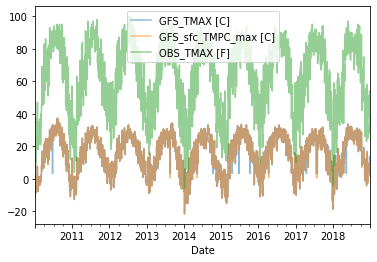

In [24]:
# Training data, x: TMAX from daily_gfs (in deg C)
GFS_TMAX_train = daily_gfs['TMAX']['2010-01-02 06:00:00':'2018-12-31 06:00:00'].resample('D').mean()  # select 2010-01-01 to 2018-12-30
print(GFS_TMAX_train)
GFS_TMAX_train.plot(alpha = 0.5, label = 'GFS_TMAX [C]');

# Training data, x: daily TMAX from sfc_gfs (in deg C)
GFS_sfc_TMPC_max_train = sfc_gfs['TMPC'].astype(float).resample('24H',base=6).max()['2010-01-02 06:00:00':'2018-12-31 06:00:00'].resample('D').mean()
print(GFS_sfc_TMPC_max_train)
GFS_sfc_TMPC_max_train.plot(alpha = 0.5, label = 'GFS_sfc_TMPC_max [C]');

# Training data, y: daily_obs & Mask Missing Data (in deg F)
mask_missing = daily_obs['Max Hourly Temp (F)'] == 'M'
OBS_TMAX_train = daily_obs['Max Hourly Temp (F)'].mask(mask_missing).dropna().astype(float)['2010-01-02':'2018-12-31']
#OBS_TMAX_train = daily_obs['Max Hourly Temp (F)'].mask(mask_missing).astype(float)['2010-01-02':'2018-12-31']
print(OBS_TMAX_train)
OBS_TMAX_train.plot(alpha = 0.5, label = 'OBS_TMAX [F]');
plt.legend(loc = 'best')

#### Validation data

2019-01-01     3.54
2019-01-02     1.54
2019-01-03     4.74
2019-01-04     5.24
2019-01-05     9.54
              ...  
2019-12-27    11.84
2019-12-28    13.94
2019-12-29    15.94
2019-12-30     7.24
2019-12-31    -0.36
Freq: D, Name: TMAX, Length: 365, dtype: float64
2019-01-01     3.54
2019-01-02     1.34
2019-01-03     4.64
2019-01-04     5.14
2019-01-05     9.54
              ...  
2019-12-27    11.84
2019-12-28    13.84
2019-12-29    15.64
2019-12-30     9.34
2019-12-31    -0.36
Freq: D, Name: TMPC, Length: 365, dtype: float64
Date
2019-01-01    37.0
2019-01-02    32.0
2019-01-03    38.0
2019-01-04    39.0
2019-01-05    51.0
              ... 
2019-12-27    43.0
2019-12-28    56.0
2019-12-29    59.0
2019-12-30    38.0
2019-12-31    33.0
Name: Max Hourly Temp (F), Length: 365, dtype: float64


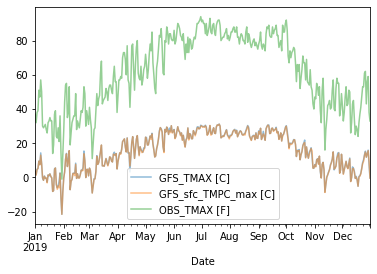

In [26]:
# Validation data, x: TMAX from daily_gfs (in deg C)
GFS_TMAX_pred = daily_gfs['TMAX']['2019-01-01 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()  
print(GFS_TMAX_pred)
GFS_TMAX_pred.plot(alpha = 0.5, label = 'GFS_TMAX [C]');

# Validation data, x: daily TMAX from sfc_gfs (in deg C)
GFS_sfc_TMPC_max_pred = sfc_gfs['TMPC'].astype(float).resample('24H',base=6).max()['2019-01-01 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
print(GFS_sfc_TMPC_max_pred)
GFS_sfc_TMPC_max_pred.plot(alpha = 0.5, label = 'GFS_sfc_TMPC_max [C]');

# Validation data, y: daily_obs & Mask Missing Data (in deg F)
mask_missing = daily_obs['Max Hourly Temp (F)'] == 'M'
OBS_TMAX_pred = daily_obs['Max Hourly Temp (F)'].mask(mask_missing).dropna().astype(float)['2019-01-01':'2019-12-31']
#OBS_TMAX_pred = daily_obs['Max Hourly Temp (F)'].mask(mask_missing).astype(float)['2019-01-01':'2019-12-31']
print(OBS_TMAX_pred)
OBS_TMAX_pred.plot(alpha = 0.5, label = 'OBS_TMAX [F]');
plt.legend(loc = 'best')

## TMIN

### Prepare training and validation data for TMIN from GFS and observation

#### Training data

2010-01-02   -16.46
2010-01-03   -15.96
2010-01-04   -14.36
2010-01-05   -12.86
2010-01-06   -11.06
              ...  
2018-12-27     5.04
2018-12-28     0.04
2018-12-29    -2.66
2018-12-30    -3.16
2018-12-31     1.54
Freq: D, Name: TMIN, Length: 3286, dtype: float64
2010-01-02   -16.06
2010-01-03   -16.46
2010-01-04   -14.36
2010-01-05   -12.86
2010-01-06   -11.66
              ...  
2018-12-27     5.04
2018-12-28     0.84
2018-12-29    -2.26
2018-12-30    -3.06
2018-12-31     0.34
Freq: D, Name: TMPC, Length: 3286, dtype: float64
Date
2010-01-02    -5.0
2010-01-03    -6.0
2010-01-04    -2.0
2010-01-05    -1.0
2010-01-06    -3.0
              ... 
2018-12-26    24.0
2018-12-27    39.0
2018-12-28    28.0
2018-12-29    23.0
2018-12-30    18.0
Name: Min Hourly Temp (F), Length: 3261, dtype: float64


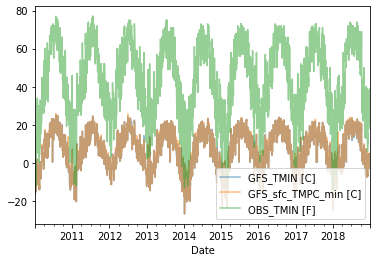

In [32]:
# Training data, x: TMIN from daily_gfs (in deg C)
GFS_TMIN_train = daily_gfs['TMIN']['2010-01-02 06:00:00':'2018-12-31 06:00:00'].resample('D').mean()  # select 2010-01-01 to 2018-12-30
print(GFS_TMIN_train)
GFS_TMIN_train.plot(alpha = 0.5, label = 'GFS_TMIN [C]');

# Training datad, x: daily TMIN from sfc_gfs (in deg C)
GFS_sfc_TMPC_min_train = sfc_gfs['TMPC'].astype(float).resample('24H',base=6).min()['2010-01-02 06:00:00':'2018-12-31 06:00:00'].resample('D').mean()
print(GFS_sfc_TMPC_min_train)
GFS_sfc_TMPC_min_train.plot(alpha = 0.5, label = 'GFS_sfc_TMPC_min [C]');

# Training data, y: daily_obs & Mask Missing Data (in deg F)
mask_missing = daily_obs['Min Hourly Temp (F)'] == 'M'
OBS_TMIN_train = daily_obs['Min Hourly Temp (F)'].mask(mask_missing).dropna().astype(float)['2010-01-02':'2018-12-31']
print(OBS_TMIN_train)
OBS_TMIN_train.plot(alpha = 0.5, label = 'OBS_TMIN [F]');
plt.legend(loc = 'best')

#### Validation data

2019-01-01   -0.86
2019-01-02   -1.16
2019-01-03   -2.26
2019-01-04   -0.06
2019-01-05    0.64
              ... 
2019-12-27    3.84
2019-12-28    3.54
2019-12-29    9.34
2019-12-30   -1.66
2019-12-31   -2.26
Freq: D, Name: TMIN, Length: 365, dtype: float64
2019-01-01    -0.16
2019-01-02    -0.86
2019-01-03    -2.26
2019-01-04    -0.16
2019-01-05     0.54
              ...  
2019-12-27     4.54
2019-12-28     3.64
2019-12-29    10.44
2019-12-30    -1.26
2019-12-31    -2.06
Freq: D, Name: TMPC, Length: 365, dtype: float64
Date
2019-01-01    32.0
2019-01-02    28.0
2019-01-03    26.0
2019-01-04    25.0
2019-01-05    30.0
              ... 
2019-12-27    32.0
2019-12-28    32.0
2019-12-29    41.0
2019-12-30    31.0
2019-12-31    30.0
Name: Min Hourly Temp (F), Length: 365, dtype: float64


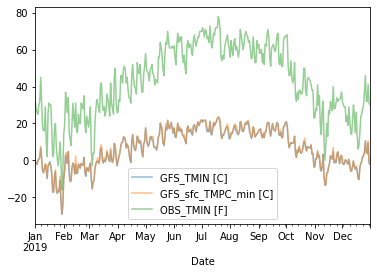

In [33]:
# Validation data, x: TMIN from daily_gfs (in deg C)
GFS_TMIN_pred = daily_gfs['TMIN']['2019-01-01 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()  # select 2010-01-01 to 2018-12-30
print(GFS_TMIN_pred)
GFS_TMIN_pred.plot(alpha = 0.5, label = 'GFS_TMIN [C]');

# Validation data, x: daily TMIN from sfc_gfs (in deg C)
GFS_sfc_TMPC_min_pred = sfc_gfs['TMPC'].astype(float).resample('24H',base=6).min()['2019-01-01 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
print(GFS_sfc_TMPC_min_pred)
GFS_sfc_TMPC_min_pred.plot(alpha = 0.5, label = 'GFS_sfc_TMPC_min [C]');

# Validation data, y: daily_obs & Mask Missing Data (in deg F)
mask_missing = daily_obs['Min Hourly Temp (F)'] == 'M'
#OBS_TMAX_train = daily_obs['Max Hourly Temp (F)'].mask(mask_missing).dropna().astype(float)['2010-01-02':'2018-12-31']
OBS_TMIN_pred = daily_obs['Min Hourly Temp (F)'].mask(mask_missing).dropna().astype(float)['2019-01-01':'2019-12-31']
print(OBS_TMIN_pred)
OBS_TMIN_pred.plot(alpha = 0.5, label = 'OBS_TMIN [F]');
plt.legend(loc = 'best')

## Max Wind (WMAX)

### Prepare training and validation data for WMAX from GFS and observation

#### Training data

2010-01-02     7.323933
2010-01-03     4.687217
2010-01-04     5.941380
2010-01-05     5.685068
2010-01-06     3.794733
                ...    
2018-12-27    10.288343
2018-12-28     7.990620
2018-12-29     5.001000
2018-12-30     6.580274
2018-12-31     8.139410
Freq: D, Name: WMAX, Length: 3286, dtype: float64
2010-01-02     7.323933
2010-01-03     4.687217
2010-01-04     5.941380
2010-01-05     5.685068
2010-01-06     3.794733
                ...    
2018-12-27    10.288343
2018-12-28     7.963040
2018-12-29     5.186521
2018-12-30     6.440497
2018-12-31     6.332456
Freq: D, Name: WSPD, Length: 3286, dtype: float64
Date
2010-01-02    15.0
2010-01-03    11.0
2010-01-04    20.0
2010-01-05    16.0
2010-01-06     8.0
              ... 
2018-12-26    15.0
2018-12-27    33.0
2018-12-28    23.0
2018-12-29    16.0
2018-12-30    21.0
Name: Max Wind Speed (mph), Length: 3264, dtype: float64


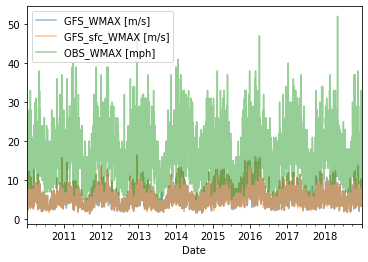

In [38]:
# Training data, x: WMAX from daily_gfs (in m/s)
GFS_WMAX_train = daily_gfs['WMAX']['2010-01-02 06:00:00':'2018-12-31 06:00:00'].resample('D').mean()  # select 2010-01-01 to 2018-12-30
print(GFS_WMAX_train)
GFS_WMAX_train.plot(alpha = 0.5, label = 'GFS_WMAX [m/s]');

# Training data, x: daily max WSPD from sfc_gfs (in m/s)
GFS_sfc_WMAX_train = sfc_gfs['WSPD'].astype(float).resample('24H',base=6).max()['2010-01-02 06:00:00':'2018-12-31 06:00:00'].resample('D').mean()
print(GFS_sfc_WMAX_train)
GFS_sfc_WMAX_train.plot(alpha = 0.5, label = 'GFS_sfc_WMAX [m/s]');

# Training data, y: daily_obs & Mask Missing Data (in mph)
mask_missing = daily_obs['Max Wind Speed (mph)'] == 'M'
OBS_WMAX_train = daily_obs['Max Wind Speed (mph)'].mask(mask_missing).dropna().astype(float)['2010-01-02':'2018-12-31']
print(OBS_WMAX_train)
OBS_WMAX_train.plot(alpha = 0.5, label = 'OBS_WMAX [mph]');
plt.legend(loc = 'best')

#### Validation data

2019-01-01     5.423099
2019-01-02     5.859181
2019-01-03     4.609772
2019-01-04     3.667424
2019-01-05     4.701064
                ...    
2019-12-27     4.301163
2019-12-28     8.819297
2019-12-29     9.701546
2019-12-30    11.111256
2019-12-31     8.769265
Freq: D, Name: WMAX, Length: 365, dtype: float64
2019-01-01     5.675385
2019-01-02     5.859181
2019-01-03     4.785394
2019-01-04     3.324154
2019-01-05     4.701064
                ...    
2019-12-27     3.687818
2019-12-28     7.823043
2019-12-29     8.796590
2019-12-30    11.111256
2019-12-31     8.928606
Freq: D, Name: WSPD, Length: 365, dtype: float64
Date
2019-01-01    14.0
2019-01-02    17.0
2019-01-03    14.0
2019-01-04    11.0
2019-01-05    14.0
              ... 
2019-12-27    15.0
2019-12-28    23.0
2019-12-29    23.0
2019-12-30    26.0
2019-12-31    29.0
Name: Max Wind Speed (mph), Length: 364, dtype: float64


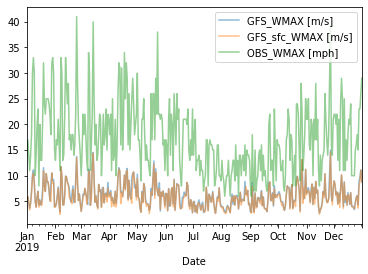

In [39]:
# Validation data, x: WMAX from daily_gfs (in m/s)
GFS_WMAX_pred = daily_gfs['WMAX']['2019-01-01 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()  # select 2010-01-01 to 2018-12-30
print(GFS_WMAX_pred)
GFS_WMAX_pred.plot(alpha = 0.5, label = 'GFS_WMAX [m/s]');

# Validation data, x: daily max WSPD from sfc_gfs (in m/s)
GFS_sfc_WMAX_pred = sfc_gfs['WSPD'].astype(float).resample('24H',base=6).max()['2019-01-01 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
print(GFS_sfc_WMAX_pred)
GFS_sfc_WMAX_pred.plot(alpha = 0.5, label = 'GFS_sfc_WMAX [m/s]');

# Validation data, y: daily_obs & Mask Missing Data (in mph)
mask_missing = daily_obs['Max Wind Speed (mph)'] == 'M'
OBS_WMAX_pred = daily_obs['Max Wind Speed (mph)'].mask(mask_missing).dropna().astype(float)['2019-01-01':'2019-12-31']
print(OBS_WMAX_pred)
OBS_WMAX_pred.plot(alpha = 0.5, label = 'OBS_WMAX [mph]');
plt.legend(loc = 'best')

## Precipitation (PRCP)

### Prepare training and validation data for PRECIP from GFS and observation

In [0]:
# Treat trace precip as 0:
daily_gfs[daily_gfs['RTOT'] < 0] = 0 # Takes care of trace precip
sfc_gfs[sfc_gfs['PRCP'] < 0] = 0

#### Training data

2010-01-02     0.05
2010-01-03     0.00
2010-01-04     0.06
2010-01-05     0.17
2010-01-06     0.77
              ...  
2018-12-27     9.94
2018-12-28     0.18
2018-12-29     0.00
2018-12-30     0.00
2018-12-31    29.71
Freq: D, Name: RTOT, Length: 3286, dtype: float64
2010-01-02     0.05
2010-01-03     0.00
2010-01-04     0.03
2010-01-05     0.20
2010-01-06     0.11
              ...  
2018-12-27     9.97
2018-12-28     0.15
2018-12-29     0.03
2018-12-30     0.00
2018-12-31    29.63
Freq: D, Name: PRCP, Length: 3286, dtype: float64
Date
2010-01-02     0.0
2010-01-03     0.0
2010-01-04     0.0
2010-01-05     0.0
2010-01-06     5.6
              ... 
2018-12-27    13.9
2018-12-28     0.0
2018-12-29     0.0
2018-12-30     9.0
2018-12-31    27.4
Name: Total Precip from Hourly (mm), Length: 3286, dtype: float64


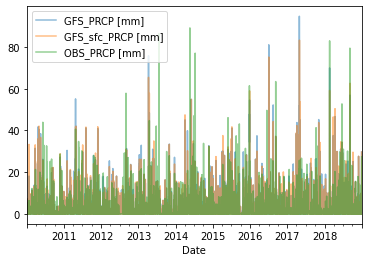

In [45]:
# Training data, x: RTOT from daily_gfs (in mm)
GFS_PRCP_train = daily_gfs['RTOT']['2010-01-02 06:00:00':'2018-12-31 06:00:00'].resample('D').mean()  # select 2010-01-01 to 2018-12-30
print(GFS_PRCP_train)
GFS_PRCP_train.plot(alpha = 0.5, label = 'GFS_PRCP [mm]');

# Training data, x: daily total PRCP from sfc_gfs (in mm)
GFS_sfc_PRCP_train = sfc_gfs['PRCP'].astype(float).resample('24H',base=6).sum()['2010-01-02 06:00:00':'2018-12-31 06:00:00'].resample('D').mean()
print(GFS_sfc_PRCP_train)
GFS_sfc_PRCP_train.plot(alpha = 0.5, label = 'GFS_sfc_PRCP [mm]');

# Training data, y: daily_obs & Mask Missing Data (in mm)
#mask_missing = daily_obs['Total Precip from Hourly (mm)'] == 'M'
#OBS_WMAX_train = daily_obs['Max Wind Speed (mph)'].mask(mask_missing).astype(float)['2010-01-02':'2018-12-31']
OBS_PRCP_train = daily_obs['Total Precip from Hourly (mm)'].dropna().astype(float)['2010-01-02':'2018-12-31']
print(OBS_PRCP_train)
OBS_PRCP_train.plot(alpha = 0.5, label = 'OBS_PRCP [mm]');
plt.legend(loc = 'best')

#### Validation data

2019-01-01     0.50
2019-01-02     0.14
2019-01-03     0.00
2019-01-04     0.00
2019-01-05     0.00
              ...  
2019-12-27     0.00
2019-12-28     2.73
2019-12-29    11.58
2019-12-30     2.57
2019-12-31     0.04
Freq: D, Name: RTOT, Length: 365, dtype: float64
2019-01-01     0.49
2019-01-02     0.23
2019-01-03     0.00
2019-01-04     0.00
2019-01-05     0.00
              ...  
2019-12-27     0.08
2019-12-28     1.19
2019-12-29    12.34
2019-12-30     3.34
2019-12-31     0.05
Freq: D, Name: PRCP, Length: 365, dtype: float64
Date
2019-01-01    0.3
2019-01-02    0.0
2019-01-03    0.0
2019-01-04    0.0
2019-01-05    0.0
             ... 
2019-12-27    0.0
2019-12-28    5.9
2019-12-29    1.8
2019-12-30    0.0
2019-12-31    0.0
Name: Total Precip from Hourly (mm), Length: 365, dtype: float64


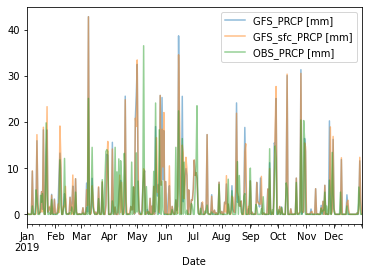

In [46]:
# Validation data, x: RTOT from daily_gfs (in mm)
GFS_PRCP_pred = daily_gfs['RTOT']['2019-01-01 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()  # select 2010-01-01 to 2018-12-30
print(GFS_PRCP_pred)
GFS_PRCP_pred.plot(alpha = 0.5, label = 'GFS_PRCP [mm]');

# Validation data, x: daily total PRCP from sfc_gfs (in mm)
GFS_sfc_PRCP_pred = sfc_gfs['PRCP'].astype(float).resample('24H',base=6).sum()['2019-01-01 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
print(GFS_sfc_PRCP_pred)
GFS_sfc_PRCP_pred.plot(alpha = 0.5, label = 'GFS_sfc_PRCP [mm]');

# Validation data, y: daily_obs & Mask Missing Data (in mm)
OBS_PRCP_pred = daily_obs['Total Precip from Hourly (mm)'].dropna().astype(float)['2019-01-01':'2019-12-31']
print(OBS_PRCP_pred)
OBS_PRCP_pred.plot(alpha = 0.5, label = 'OBS_PRCP [mm]');
plt.legend(loc = 'best')

# Linear regression model


## TMAX

### Training

Model slope:     [0.63821889 0.43603917]
Model intercept: 0.0


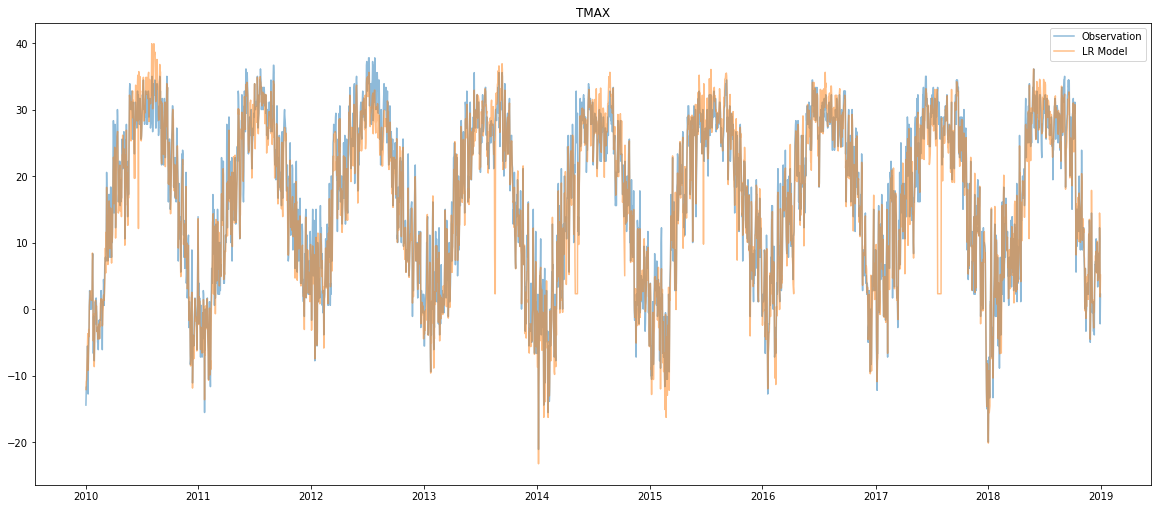

In [51]:
# making sure training set has the same length in X and y: 
 # OBS has missing dates while GFS don't, so find missing dates and drop those 
 # in GFS data.
mismatch_dates = GFS_TMAX_train.index.difference(OBS_TMAX_train.index)  # OBS doesn't have these dates

# Training
X = np.column_stack((GFS_TMAX_train.drop(mismatch_dates).values, GFS_sfc_TMPC_max_train.drop(mismatch_dates).values))  # GFS model daily and sfc max TMPC
y = (OBS_TMAX_train.values-32)*5/9  # Observation, converted from F to C

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

print("Model slope:    ", model.coef_)
print("Model intercept:", model.intercept_)

# Calculate model result for the training period and visualize it
y_model = model.predict(X)
# y_predict = X[:, 0] * model.coef_[0] + X[:, 1] * model.coef_[1] + model.intercept_  # another form to write the equation

plt.figure(figsize=(20, 8.5))
# plt.plot(OBS_TMAX_dates, X, alpha=0.5)
plt.plot(OBS_TMAX_train.index, y, alpha=0.5, label='Observation')
plt.plot(OBS_TMAX_train.index, y_model, alpha=0.5, label='LR Model')
plt.title('TMAX')
plt.legend()
plt.show()


### Validation

RMS of TMAX LR:  2.014288779179854


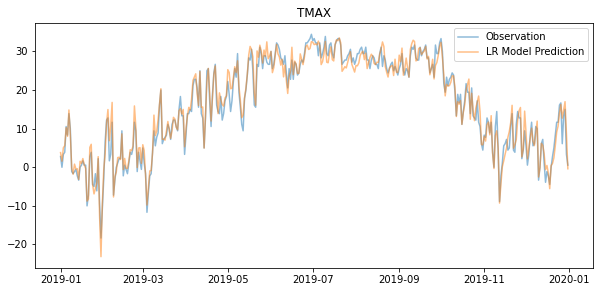

In [52]:
# Validation
mismatch_dates = GFS_TMAX_pred.index.difference(OBS_TMAX_pred.index)

X_predict = np.column_stack((GFS_TMAX_pred.drop(mismatch_dates).values, GFS_sfc_TMPC_max_pred.drop(mismatch_dates).values))
y_predict = model.predict(X_predict)  # linear regression model prediction
y_true = (OBS_TMAX_pred.values-32)*5/9  # Observation, converted from F to C

rms_TMAX_LR = sqrt(mean_squared_error(y_true, y_predict))
print('RMS of TMAX LR: ', rms_TMAX_LR)

plt.figure(figsize=(10, 4.5))
# plt.plot(OBS_TMAX_dates, X, alpha=0.5)
plt.plot(OBS_TMAX_pred.index, y_true, alpha=0.5, label='Observation')
plt.plot(OBS_TMAX_pred.index, y_predict, alpha=0.5, label='LR Model Prediction')
plt.title('TMAX')
plt.legend()
plt.show()

## TMIN

Model slope:     [0.82141897 0.18410693]
Model intercept: 0.0


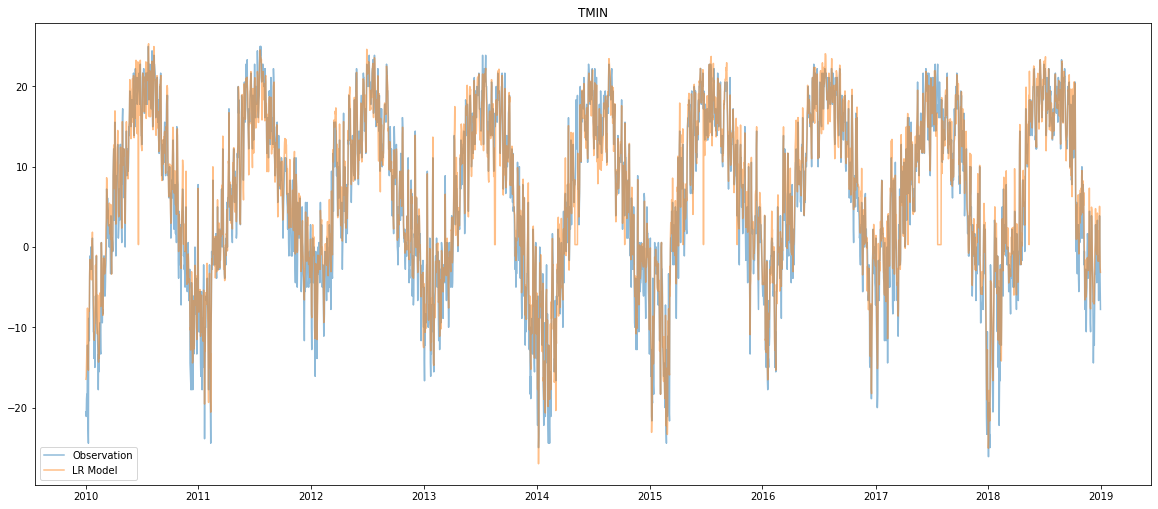

In [53]:
mismatch_dates = GFS_TMIN_train.index.difference(OBS_TMIN_train.index)  # OBS doesn't have these dates

# Training
X = np.column_stack((GFS_TMIN_train.drop(mismatch_dates).values, GFS_sfc_TMPC_min_train.drop(mismatch_dates).values))  # GFS model daily and sfc max TMPC
y = (OBS_TMIN_train.values-32)*5/9  # Observation, converted from F to C

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

print("Model slope:    ", model.coef_)
print("Model intercept:", model.intercept_)

# Calculate model result for the training period and visualize it
y_model = model.predict(X)
# y_predict = X[:, 0] * model.coef_[0] + X[:, 1] * model.coef_[1] + model.intercept_  # another form to write the equation

plt.figure(figsize=(20, 8.5))
# plt.plot(OBS_TMAX_dates, X, alpha=0.5)
plt.plot(OBS_TMIN_train.index, y, alpha=0.5, label='Observation')
plt.plot(OBS_TMIN_train.index, y_model, alpha=0.5, label='LR Model')
plt.title('TMIN')
plt.legend()
plt.show()


RMS of TMIN LR:  2.1495980937499004


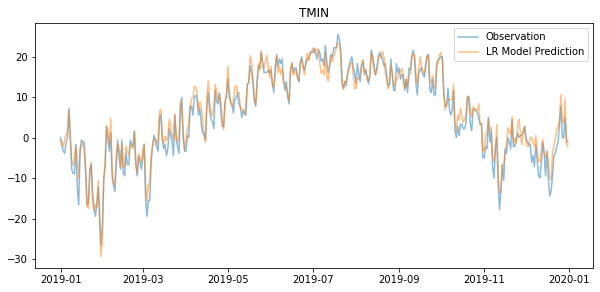

In [54]:
# Validation
mismatch_dates = GFS_TMIN_pred.index.difference(OBS_TMIN_pred.index)

X_predict = np.column_stack((GFS_TMIN_pred.drop(mismatch_dates).values, GFS_sfc_TMPC_min_pred.drop(mismatch_dates).values))
y_predict = model.predict(X_predict)  # linear regression model prediction
y_true = (OBS_TMIN_pred.values-32)*5/9  # Observation, converted from F to C

rms_TMIN_LR = sqrt(mean_squared_error(y_true, y_predict))
print('RMS of TMIN LR: ', rms_TMIN_LR)

plt.figure(figsize=(10, 4.5))
# plt.plot(OBS_TMAX_dates, X, alpha=0.5)
plt.plot(OBS_TMIN_pred.index, y_true, alpha=0.5, label='Observation')
plt.plot(OBS_TMIN_pred.index, y_predict, alpha=0.5, label='LR Model Prediction')
plt.title('TMIN')
plt.legend()
plt.show()

## Max Wind

Model slope:     [0.79900624 0.48438901]
Model intercept: 0.0


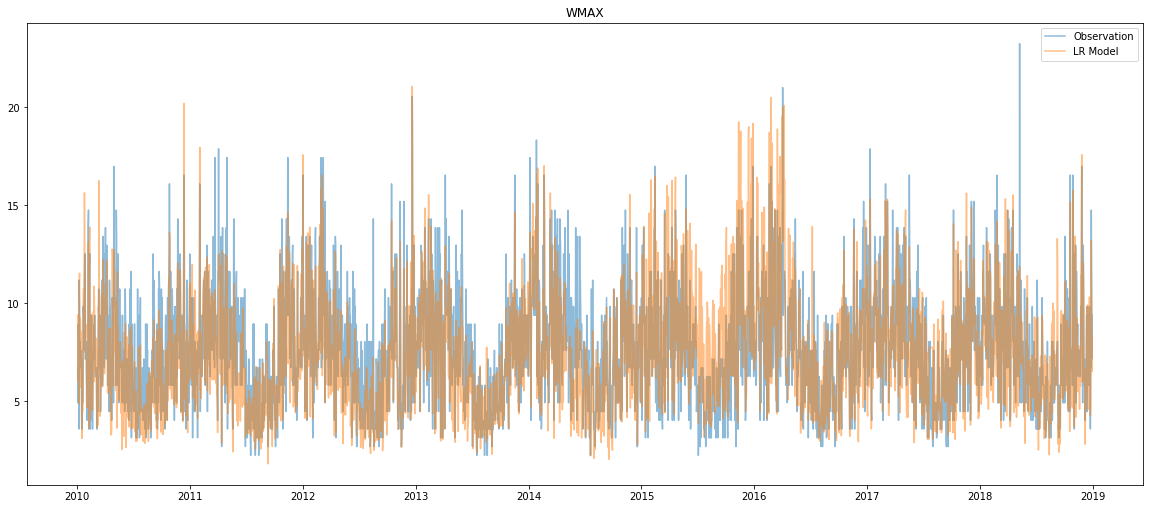

In [55]:
mismatch_dates = GFS_WMAX_train.index.difference(OBS_WMAX_train.index)  # OBS doesn't have these dates

# Training
X = np.column_stack((GFS_WMAX_train.drop(mismatch_dates).values, GFS_sfc_WMAX_train.drop(mismatch_dates).values))  # GFS model daily and sfc max TMPC
y = OBS_WMAX_train.values*0.44704  # Observation, converted from mph to m/s

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

print("Model slope:    ", model.coef_)
print("Model intercept:", model.intercept_)

# Calculate model result for the training period and visualize it
y_model = model.predict(X)
# y_predict = X[:, 0] * model.coef_[0] + X[:, 1] * model.coef_[1] + model.intercept_  # another form to write the equation

plt.figure(figsize=(20, 8.5))
# plt.plot(OBS_TMAX_dates, X, alpha=0.5)
plt.plot(OBS_WMAX_train.index, y, alpha=0.5, label='Observation')
plt.plot(OBS_WMAX_train.index, y_model, alpha=0.5, label='LR Model')
plt.title('WMAX')
plt.legend()
plt.show()


RMS of WMAX LR:  1.6532687009155704


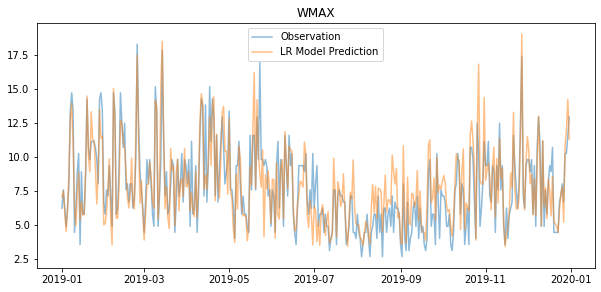

In [56]:
# Validation
mismatch_dates = GFS_WMAX_pred.index.difference(OBS_WMAX_pred.index)

X_predict = np.column_stack((GFS_WMAX_pred.drop(mismatch_dates).values, GFS_sfc_WMAX_pred.drop(mismatch_dates).values))
y_predict = model.predict(X_predict)  # linear regression model prediction
y_true = OBS_WMAX_pred.values*0.44704  # Observation, converted from mph to m/s  

rms_WMAX_LR = sqrt(mean_squared_error(y_true, y_predict))
print('RMS of WMAX LR: ', rms_WMAX_LR)

plt.figure(figsize=(10, 4.5))
# plt.plot(OBS_TMAX_dates, X, alpha=0.5)
plt.plot(OBS_WMAX_pred.index, y_true, alpha=0.5, label='Observation')
plt.plot(OBS_WMAX_pred.index, y_predict, alpha=0.5, label='LR Model Prediction')
plt.title('WMAX')
plt.legend()
plt.show()

## Precipitation

Model slope:     [ 0.76860373 -0.2689613 ]
Model intercept: 0.0


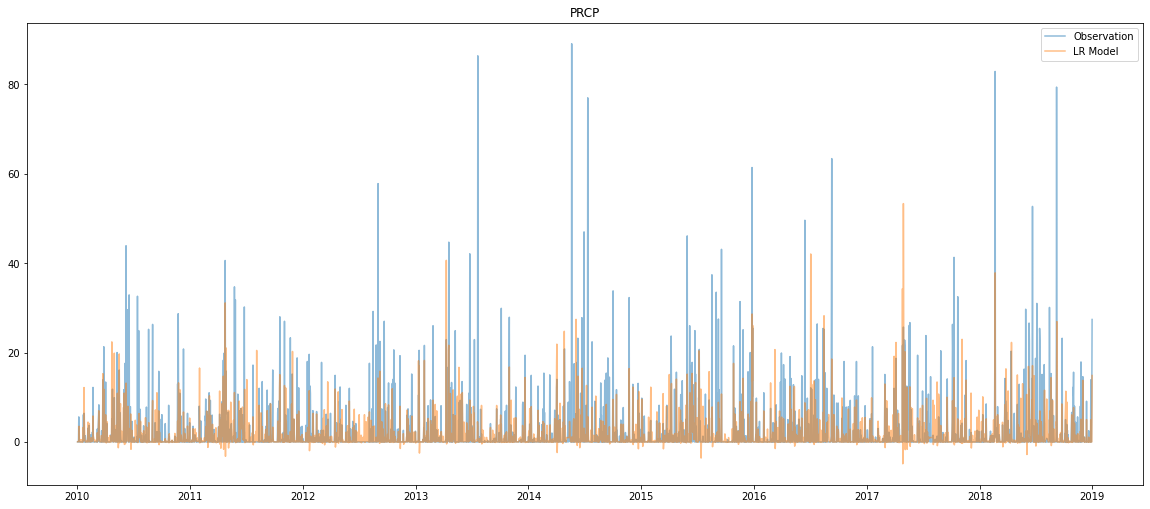

In [57]:
mismatch_dates = GFS_PRCP_train.index.difference(OBS_PRCP_train.index)  # OBS doesn't have these dates

# Training
X = np.column_stack((GFS_PRCP_train.drop(mismatch_dates).values, GFS_sfc_PRCP_train.drop(mismatch_dates).values))  # GFS model daily and sfc max TMPC
y = OBS_PRCP_train.values  # Observation

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

print("Model slope:    ", model.coef_)
print("Model intercept:", model.intercept_)

# Calculate model result for the training period and visualize it
y_model = model.predict(X)
# y_predict = X[:, 0] * model.coef_[0] + X[:, 1] * model.coef_[1] + model.intercept_  # another form to write the equation

plt.figure(figsize=(20, 8.5))
# plt.plot(OBS_TMAX_dates, X, alpha=0.5)
plt.plot(OBS_PRCP_train.index, y, alpha=0.5, label='Observation')
plt.plot(OBS_PRCP_train.index, y_model, alpha=0.5, label='LR Model')
plt.title('PRCP')
plt.legend()
plt.show()


RMS of PRCP LR:  4.252920551449257


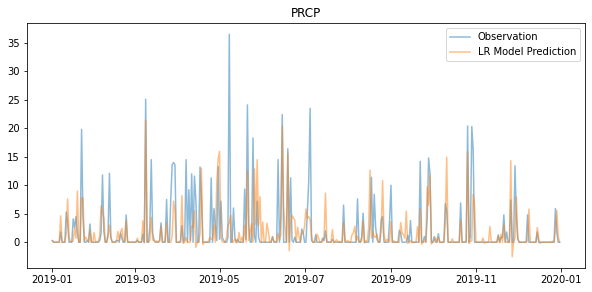

In [58]:
# Validation
mismatch_dates = GFS_PRCP_pred.index.difference(OBS_PRCP_pred.index)

X_predict = np.column_stack((GFS_PRCP_pred.drop(mismatch_dates).values, GFS_sfc_PRCP_pred.drop(mismatch_dates).values))
y_predict = model.predict(X_predict)  # linear regression model prediction
y_true = OBS_PRCP_pred.values  # Observation

rms_PRCP_LR = sqrt(mean_squared_error(y_true, y_predict))
print('RMS of PRCP LR: ', rms_PRCP_LR)

plt.figure(figsize=(10, 4.5))
# plt.plot(OBS_TMAX_dates, X, alpha=0.5)
plt.plot(OBS_PRCP_pred.index, y_true, alpha=0.5, label='Observation')
plt.plot(OBS_PRCP_pred.index, y_predict, alpha=0.5, label='LR Model Prediction')
plt.title('PRCP')
plt.legend()
plt.show()

In [59]:
RMS_LR = [rms_TMAX_LR, rms_TMIN_LR, rms_WMAX_LR, rms_PRCP_LR]
RMS_LR

[2.014288779179854, 2.1495980937499004, 1.6532687009155704, 4.252920551449257]

# **DID NOT UPDATE ANYTHING BELOW (XL, 03.30)**

# Random forest regression model

## TMAX

In [60]:
X = np.column_stack((GFS_TMAX[GFS_TMAX_dates.strftime('%Y-%m-%d')].values, GFS_sfc_TMPC_max.values))  # GFS model daily and sfc max TMPC
y = (OBS_TMAX[OBS_TMAX_dates.strftime('%Y-%m-%d')].values-32)*5/9  # Observation, converted from F to C

forest = RandomForestRegressor(200)
forest.fit(X, y)
y_predict = forest.predict(X)

plt.figure(figsize=(20, 8.5))
# plt.plot(OBS_TMAX_dates, X, alpha=0.5)
plt.plot(OBS_TMAX_dates, y, alpha=0.5, label='Observation')
plt.plot(OBS_TMAX_dates, y_predict, alpha=0.5, label='Prediction')
plt.legend()
plt.show()

rms_TMAX_RF = sqrt(mean_squared_error(y, y_predict))
print('RMS of linear regression: ', rms_TMAX_LR)
print('RMS of random forest:     ', rms_TMAX_RF)

NameError: ignored

## TMIN

## PRECIP

In [0]:
daily_gfs['RTOT'].index

In [0]:
# prepare prediction data: precip from daily_gfs and sfc_gfs
GFS_PRCP_pred = daily_gfs['RTOT']['2019-01-01 06:00:00':'2020-01-01 06:00:00']  # select 2019-01-01 to 2020-01-01 # shouldn't we shift this for 18 hours?
GFS_PRCP_pred.index = GFS_PRCP_pred.index.strftime('%Y-%m-%d')  # to be consistent with observation index
print(GFS_PRCP_pred) # in mm
#GFS_PRCP_pred.plot();
#sfc_gfs.index = pd.to_datetime(sfc_gfs.index, format='%Y-%m-%d %H:%M:%S')
#sfc_gfs[sfc_gfs['PRCP'] < 0] = 0 # Takes care of trace precip
GFS_sfc_PRCP_pred = sfc_gfs['PRCP'].astype(float).resample('24H',base=6).sum()['2019-01-01 06:00:00':'2019-12-31 06:00:00'].resample('D').mean()
print(GFS_sfc_PRCP_pred) # in mm


In [0]:
# prepare validation data: observations from 2019-01-01 to 2019-12-31
mask_missing = daily_obs['Total Precip from Hourly (mm)'] == 'M'
OBS_PRCP_pred = daily_obs['Total Precip from Hourly (mm)'].mask(mask_missing).dropna().astype(float)['2019-01-01':'2020-01-01']
print(OBS_PRCP_pred)
OBS_PRCP_pred.plot();

In [0]:
import matplotlib.dates as mdates
# training
X = np.column_stack((GFS_PRCP[GFS_PRCP_dates.strftime('%Y-%m-%d')].values, GFS_sfc_PRCP.values))  # GFS model daily and sfc total PRCP,
y = (OBS_PRCP[OBS_PRCP_dates.strftime('%Y-%m-%d')].values)  # Observation
forest = RandomForestRegressor(200)
forest.fit(X, y)

# prediction
X_predict = np.column_stack((GFS_PRCP_pred.values, GFS_sfc_PRCP_pred.values)) 
y_predict = forest.predict(X_predict)

fig, ax = plt.subplots(1, 1, figsize=(20, 8.5))
# plt.plot(OBS_TMAX_dates, X, alpha=0.5)
plt.plot(OBS_PRCP_pred.index, OBS_PRCP_pred.values, alpha=0.5, label='Observation')
plt.plot(OBS_PRCP_pred.index, y_predict, alpha=0.5, label='Prediction')
plt.legend()
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# fig.autofmt_xdate()
plt.show()

# plt.plot(OBS_PRCP_pred, y, alpha=0.5, label='Observation')
# plt.plot(OBS_PRCP_dates, y_predict, alpha=0.5, label='Prediction')

rms_PRCP_RF = sqrt(mean_squared_error(OBS_PRCP_pred.values, y_predict))
#print('RMS of linear regression: ', rms_PRCP_LR)
print('RMS of random forest:     ', rms_PRCP_RF)

## Max Wind